In [1]:
"""
Title: PixelCNN
Author: [ADMoreau](https://github.com/ADMoreau)
Date created: 2020/05/17
Last modified: 2020/05/23
Description: PixelCNN implemented in Keras.
"""

"""
## Introduction
PixelCNN is a generative model proposed in 2016 by van den Oord et al.
(reference: [Conditional Image Generation with PixelCNN Decoders](https://arxiv.org/abs/1606.05328)).
It is designed to generate images (or other data types) iteratively
from an input vector where the probability distribution of prior elements dictates the
probability distribution of later elements. In the following example, images are generated
in this fashion, pixel-by-pixel, via a masked convolution kernel that only looks at data
from previously generated pixels (origin at the top left) to generate later pixels.
During inference, the output of the network is used as a probability ditribution
from which new pixel values are sampled to generate a new image
(here, with MNIST, the pixels values are either black or white).
"""

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow_probability as tfp


ImportError: This version of TensorFlow Probability requires TensorFlow version >= 2.7; Detected an installation of version 2.4.1. Please upgrade TensorFlow to proceed.

In [ ]:

"""
## Getting the Data
"""

# Model / data parameters
num_classes = 10
input_shape = (28, 1)
n_residual_blocks = 5
# The data, split between train and test sets
(x, _), (y, _) = keras.datasets.mnist.load_data()

# Concatenate all of the images together
data = np.concatenate((x, y), axis=0)


In [7]:

# Round all pixel values less than 33% of the max 256 value to 0
# anything above this value gets rounded up to 1 so that all values are either
# 0 or 1
#data = np.where(data < (0.33 * 256), 0, 1)
data = data.astype(np.float32)
print(data.shape)
data = data[:, 10, :].reshape(data.shape[0], 28,1)

print(data.shape)


(70000, 28, 28)
(70000, 28, 1)


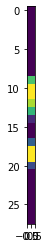

In [14]:
plt.imshow(data[5])

In [15]:

# Code for the TCN adapted from https://github.com/philipperemy/keras-tcn

def residual_block(x, training, dilation_rate, nb_filters, kernel_size, padding,
                   activation='relu', dropout_rate=0,
                   kernel_initializer='he_normal', use_batch_norm=False):
    # type: (Layer, bool, int, int, int, str, str, float, str, bool) -> Tuple[Layer, Layer]
    """Defines the residual block for the WaveNet TCN
    Args:
        x: The previous layer in the model
        training: boolean indicating whether the layer should behave in training mode or in inference mode
        dilation_rate: The dilation power of 2 we are using for this residual block
        nb_filters: The number of convolutional filters to use in this block
        kernel_size: The size of the convolutional kernel
        padding: The padding used in the convolutional layers, 'same' or 'causal'.
        activation: The final activation used in o = Activation(x + F(x))
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
        use_batch_norm: Whether to use batch normalization in the residual layers or not.
    Returns:
        A tuple where the first element is the residual model layer, and the second
        is the skip connection.
    """
    prev_x = x
    for k in range(2):
        x = tf.keras.layers.Conv1D(x, filters=nb_filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   kernel_initializer=kernel_initializer,
                   padding=padding,
                   activation=activation)
        if use_batch_norm:
            x = tf.layers.batch_normalization(x)  # TODO should be WeightNorm here, but using batchNorm instead
        #x = tf.nn.relu(x)
        x = tf.keras.layers.SpatialDropout1D(rate=dropout_rate)(inputs=x, training=training)

    # 1x1 conv to match the shapes (channel dimension).
    prev_x = tf.keras.layers.Conv1D(prev_x, nb_filters, 1, padding='same')
    res_x = prev_x + x
    res_x = tf.keras.activations.relu(res_x)
    return res_x, x

def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations

def tcn(x, nb_filters=64, kernel_size=2, nb_stacks=1, 
        dilations=(1, 2, 4, 8, 16, 32), padding='causal',
        use_skip_connections=True, dropout_rate=0.0, return_sequences=False,
        activation=tf.nn.relu, name='tcn', kernel_initializer='he_normal',
        use_batch_norm=False, training=None):

    x = tf.keras.layers.Conv1D(x, nb_filters, 1, padding=padding,
                         kernel_initializer=kernel_initializer)
    skip_connections = []
    for s in range(nb_stacks):
        for d in dilations:
            x, skip_out = residual_block(x,
                                          training=training,
                                          dilation_rate=d,
                                          nb_filters=nb_filters,
                                          kernel_size=kernel_size,
                                          padding=padding,
                                          activation=activation,
                                          dropout_rate=dropout_rate,
                                          kernel_initializer=kernel_initializer,
                                          use_batch_norm=use_batch_norm)
            skip_connections.append(skip_out)
    if use_skip_connections:
        x = tf.keras.layers.add(skip_connections)
    if not return_sequences:
        x = x[:, -1, :]
    return x


In [16]:
batch_size = 128
x = tf.placeholder(dtype=tf.float32, shape=[batch_size, 100, 1])

net = tcn(x, return_sequences=True)
net = tf.layers.dense(net, 2)

distribution = tfp.distributions.Normal(net[...,0], 1e-4 + tf.nn.softplus(net[..., 1]))

In [17]:
"""
## Build the model based on the original paper
"""

inputs = keras.Input(shape=(28,1))
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(inputs)

for _ in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

#out = keras.layers.Conv1D(
#    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
#)(x)

out = tfp.layers.MixtureNormal(num_components, event_shape)(x)


pixel_cnn = keras.Model(inputs, out)


In [ ]:
negloglik = lambda y, q: -q.log_prob(y)


In [18]:
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss=negloglik)

pixel_cnn.summary()




Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 1)]           0         
_________________________________________________________________
pixel_conv_layer (PixelConvL (None, 28, 128)           1024      
_________________________________________________________________
residual_block (ResidualBloc (None, 28, 128)           49472     
_________________________________________________________________
residual_block_1 (ResidualBl (None, 28, 128)           49472     
_________________________________________________________________
residual_block_2 (ResidualBl (None, 28, 128)           49472     
_________________________________________________________________
residual_block_3 (ResidualBl (None, 28, 128)           49472     
_________________________________________________________________
residual_block_4 (ResidualBl (None, 28, 128)           49472 

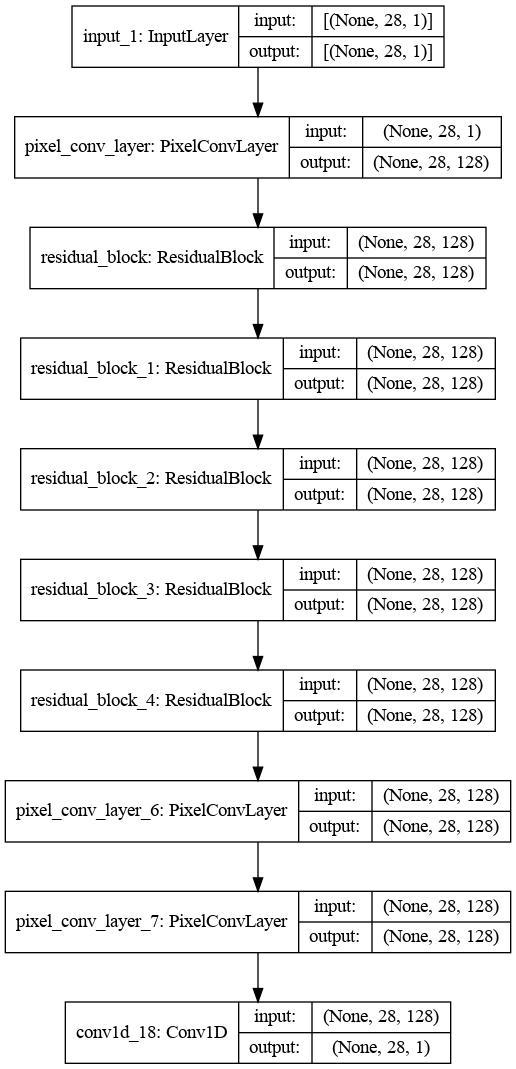

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(pixel_cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
pixel_cnn.layers[1].conv.kernel.get_shape()

TensorShape([7, 7, 1, 128])

In [ ]:
pixel_cnn.fit(
    x=data, y=data, batch_size=128, epochs=50, validation_split=0.1, verbose=2
)


In [ ]:
"""
## Demonstration
The PixelCNN cannot generate the full image at once. Instead, it must generate each pixel in
order, append the last generated pixel to the current image, and feed the image back into the
model to repeat the process.
"""

from IPython.display import Image, display

# Create an empty array of pixels.
batch = 4
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = pixel_cnn.predict(pixels)[:, row, col, channel]
            # Use the probabilities to pick pixel values and append the values to the image
            # frame.
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.random.uniform(probs.shape)
            )



In [ ]:

def deprocess_image(x):
    # Stack the single channeled black and white image to rgb values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    keras.preprocessing.image.save_img(
        "generated_image_{}.png".format(i), deprocess_image(np.squeeze(pic, -1))
    )

display(Image("generated_image_0.png"))
display(Image("generated_image_1.png"))
display(Image("generated_image_2.png"))
display(Image("generated_image_3.png"))

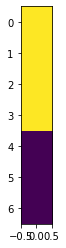

In [22]:
mask_type = "B"
kernel_shape=pixel_cnn.layers[1].conv.kernel.get_shape()
mask = np.zeros(shape=kernel_shape)
mask[: kernel_shape[0] // 2, ...] = 1.0
mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
if mask_type == "B":
    mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0
    
plt.imshow(mask[...,0])

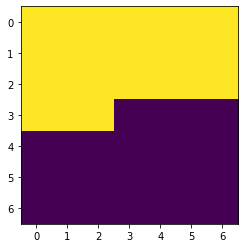